In [ ]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import random

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
unique_label= np.unique(y_train)
rand_list=[]

for i in range(len(unique_label)):
    idx = np.argwhere(y_train == unique_label[i])
    rand_index = np.random.choice(idx.shape[0], 1000, replace=False )
    idx_only= idx[:,0]
    rand_list.extend(idx_only[rand_index])
    #print()

X_train_10k= x_train[rand_list]
Y_train_10k= y_train[rand_list]

In [ ]:
#shuffle data as training set is sorted based on class:
arr = np.arange(10000)
np.random.seed(42)
np.random.shuffle(arr)
X_train= X_train_10k[arr]
Y_train= Y_train_10k[arr]

input_shape = X_train.shape[1:]

In [ ]:
def normalize_data(X_train, x_test):
    X_train1= X_train/255
    X_test = x_test/ 255

    X_train1_mean = np.mean(X_train1, axis=0)
    X_train1_std= np.std(X_train1, axis=0)
    X_train1 = (X_train1 - X_train1_mean)/X_train1_std
    X_test = (X_test- X_train1_mean)/X_train1_std

    return X_train1, X_test

In [ ]:
X_train_t, X_test_t= normalize_data(X_train, x_test)

# Convert class vectors to binary class matrices.
Y_train_t = tf.keras.utils.to_categorical(Y_train, len(unique_label))
y_test_t = tf.keras.utils.to_categorical(y_test, len(unique_label))

In [ ]:
print('x_train shape:', X_train_t.shape)
print('y_train shape:', Y_train_t.shape)

x_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 10)


In [ ]:
batch_size= 100
epochs= 100
lr= 0.001
depth=20

### RESNET20 Implementation


In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True,conv_first=True):

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
  
  conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')

  x = inputs
  if conv_first:
      x = conv(x)
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
  else:
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
      x = conv(x)
  return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0, patience=5,min_lr=0.5e-6)

callbacks = [lr_scheduler, lr_reducer]

### Baseline Model

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])

#fit model
history= model.fit(X_train_t, Y_train_t,batch_size=batch_size,epochs=epochs,validation_data=(X_test_t, y_test_t),shuffle=True,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001
100/100 [==============================] - 4s 20ms/step - loss: 2.0748 - accuracy: 0.2745 - val_loss: 2.2638 - val_accuracy: 0.2126
Epoch 2/100
Learning rate:  0.001
100/100 [==============================] - 2s 16ms/step - loss: 1.4921 - accuracy: 0.4389 - val_loss: 2.3248 - val_accuracy: 0.2273
Epoch 3/100
Learning rate:  0.001
100/100 [==============================] - 2s 16ms/step - loss: 1.2982 - accuracy: 0.5229 - val_loss: 1.6031 - val_accuracy: 0.4229
Epoch 4/100
Learning rate:  0.001
100/100 [==============================] - 2s 16ms/step - loss: 1.1070 - accuracy: 0.6020 - val_loss: 1.4884 - val_accuracy: 0.4812
Epoch 5/100
Learning rate:  0.001
100/100 [==============================] - 2s 16ms/step - loss: 0.9721 - accuracy: 0.6463 - val_loss: 1.3567 - val_accuracy: 0.5304
Epoch 6/100
Learning rate:  0.001
100/100 [==============================] - 2s 16ms/step - loss: 0.8557 - accuracy: 0.6996 - val_loss: 1.7226 - val

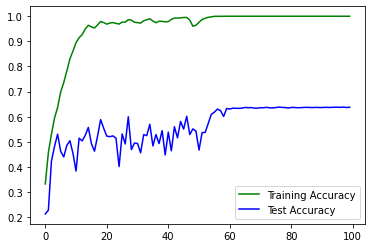

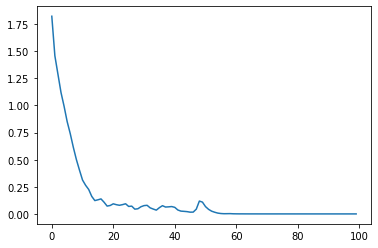

Final Train Accuracy:  1.0
Final Test Accuracy:  0.6373999714851379


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['accuracy'],'g',label="Training Accuracy")
ax.plot(history.history['val_accuracy'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history.history['accuracy'][-1])
print("Final Test Accuracy: ",history.history['val_accuracy'][-1])

### MixUp Augmentation


#### Alpha=0.2

In [ ]:
class CustomDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, Y, batch_size,alpha, shuffle=False):
        'Initialization'
        self.X= X
        self.Y= Y
        self.batch_size = batch_size
        self.indices= list(np.arange(X.shape[0]))
        self.alpha=alpha
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(X_train_t) / self.batch_size))

    def __getitem__(self, idx):
        index = self.idx[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size]

        rand_index = np.random.choice(self.X.shape[0], self.batch_size, replace=False )
        shuffled_x= self.X[rand_index]
        shuffled_y= self.Y[rand_index]

        #mixup
        gamma= np.random.beta(self.alpha, self.alpha, self.batch_size) 
        x_l = tf.reshape(gamma, (self.batch_size, 1, 1, 1))
        y_l = tf.reshape(gamma, (self.batch_size, 1))
        X_mixup = batch_x * x_l + shuffled_x * (1 - x_l)
        Y_mixup = batch_y * y_l + shuffled_y * (1 - y_l) 

        return X_mixup, Y_mixup

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idx = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.idx)


In [ ]:
traingen= CustomDataGenerator(X_train_t,  Y_train_t, batch_size, 0.2)

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])

# Train model on dataset
history= model.fit_generator(generator=traingen, epochs=100,validation_data=(X_test_t, y_test_t),  use_multiprocessing=False, workers=6)
loss, acc = model.evaluate(X_test_t, y_test_t)

Learning rate:  0.001
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 6s 33ms/step - loss: 2.1356 - accuracy: 0.2672 - val_loss: 2.3336 - val_accuracy: 0.1655
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 1.6287 - accuracy: 0.4456 - val_loss: 2.4476 - val_accuracy: 0.2287
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - loss: 1.4604 - accuracy: 0.5241 - val_loss: 1.6087 - val_accuracy: 0.4045
Epoch 4/100
100/100 [==============================] - 3s 28ms/step - loss: 1.3123 - accuracy: 0.5981 - val_loss: 1.8488 - val_accuracy: 0.4221
Epoch 5/100
100/100 [==============================] - 3s 28ms/step - loss: 1.2493 - accuracy: 0.6308 - val_loss: 1.6041 - val_accuracy: 0.4779
Epoch 6/100
100/100 [==============================] - 3s 29ms/step - loss: 1.1291 - accuracy: 0.6815 - val_loss: 1.7015 - val_accuracy: 0.4750
Epoch 7/100
100/100 [==============================] - 3s 29ms/step - loss: 1.0516 - accuracy: 0.7157 - val_loss: 1.7186 - val_accuracy: 0.4740
Epoc

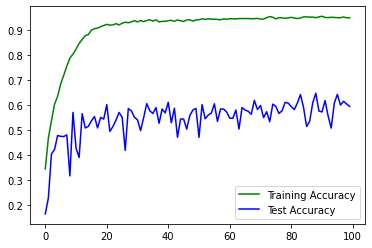

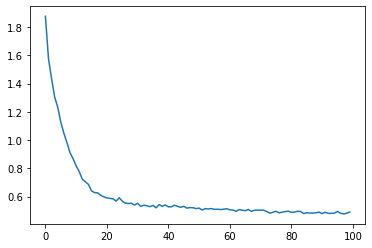

Final Train Accuracy:  0.9477999806404114
Final Test Accuracy:  0.5942000150680542


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['accuracy'],'g',label="Training Accuracy")
ax.plot(history.history['val_accuracy'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history.history['accuracy'][-1])
print("Final Test Accuracy: ",history.history['val_accuracy'][-1])

#### Alpha=0.4

In [ ]:
traingen= CustomDataGenerator(X_train_t,  Y_train_t, batch_size, 0.4)

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])

history2= model.fit_generator(traingen, epochs=epochs,validation_data=(X_test_t, y_test_t), callbacks=callbacks, workers=6)
loss, acc = model.evaluate(X_test_t, y_test_t)

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 6s 37ms/step - loss: 2.2245 - accuracy: 0.2555 - val_loss: 1.9212 - val_accuracy: 0.3140
Epoch 2/100
Learning rate:  0.001
100/100 [==============================] - 3s 32ms/step - loss: 1.7243 - accuracy: 0.4275 - val_loss: 1.8804 - val_accuracy: 0.2765
Epoch 3/100
Learning rate:  0.001
100/100 [==============================] - 3s 31ms/step - loss: 1.6002 - accuracy: 0.4992 - val_loss: 1.6329 - val_accuracy: 0.4046
Epoch 4/100
Learning rate:  0.001
100/100 [==============================] - 3s 32ms/step - loss: 1.4677 - accuracy: 0.5632 - val_loss: 1.5517 - val_accuracy: 0.4580
Epoch 5/100
Learning rate:  0.001
100/100 [==============================] - 3s 31ms/step - loss: 1.3969 - accuracy: 0.5953 - val_loss: 1.4146 - val_accuracy: 0.5065
Epoch 6/100
Learning rate:  0.001
100/100 [==============================] - 3s 32ms/step - loss: 1.3274 - accuracy: 0.6287 - val_loss: 1.6659 - val_accuracy: 0.4333
Epoch 7/100
Learning rate:  0.001
100/

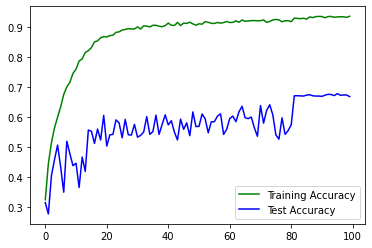

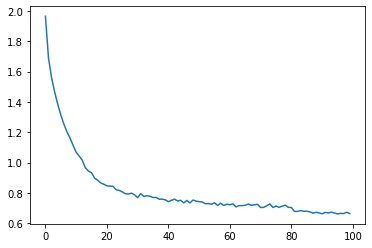

Final Train Accuracy:  0.9369000196456909
Final Test Accuracy:  0.66839998960495


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history2.history['accuracy'],'g',label="Training Accuracy")
ax.plot(history2.history['val_accuracy'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history2.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history2.history['accuracy'][-1])
print("Final Test Accuracy: ",history2.history['val_accuracy'][-1])

### CutOut Augmentation

In [ ]:
class Cutout_augment(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, Y, batch_size, K, shuffle=False):
        'Initialization'
        self.X= X
        self.Y= Y
        self.batch_size = batch_size
        self.indices= list(np.arange(X.shape[0]))
        self.K=K
        self.shuffle = shuffle
        self.on_epoch_end()
        self.h, self.w, self.channels= X[0].shape

    def __len__(self):
        return int(np.ceil(len(X_train_t) / self.batch_size))

    def __getitem__(self, idx):
        index = self.idx[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
       
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x_new= batch_x.copy()
        for i in range(self.batch_size):
            prob = np.random.rand()
            if prob>0.5:
                batch_x_new[i]= self.__apply_mask(batch_x_new[i], self.K)

        return batch_x_new, batch_y


    def __apply_mask(self, image, size):
        y = np.random.randint(self.h)
        x = np.random.randint(self.w)
        y1 = np.clip(y - size // 2, 0, self.h)
        y2 = np.clip(y + size // 2, 0, self.h)
        x1 = np.clip(x - size // 2, 0, self.w)
        x2 = np.clip(x + size // 2, 0, self.w)
        image[y1:y2,x1:x2,:] = 0
        return image

    def on_epoch_end(self):
        self.idx = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.idx)


In [ ]:
traingen= Cutout_augment(X_train_t,  Y_train_t, batch_size, 16)

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['acc'])

#fit model
history= model.fit_generator(traingen, epochs=100,validation_data=(X_test_t, y_test_t), callbacks=callbacks, workers=6)
loss, acc = model.evaluate(X_test_t, y_test_t)

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 5s 31ms/step - loss: 2.0379 - acc: 0.2512 - val_loss: 2.3345 - val_acc: 0.1752
Epoch 2/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 1.5277 - acc: 0.4407 - val_loss: 2.1012 - val_acc: 0.2908
Epoch 3/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 1.3738 - acc: 0.4959 - val_loss: 1.8389 - val_acc: 0.4079
Epoch 4/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 1.2344 - acc: 0.5490 - val_loss: 1.7379 - val_acc: 0.4412
Epoch 5/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 1.1215 - acc: 0.5985 - val_loss: 1.6840 - val_acc: 0.4813
Epoch 6/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 1.0045 - acc: 0.6437 - val_loss: 1.7882 - val_acc: 0.4828
Epoch 7/100
Learning rate:  0.001
100/100 [==============================] - 3s 27ms/step - loss: 

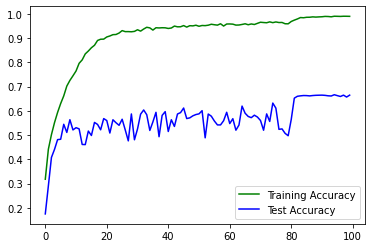

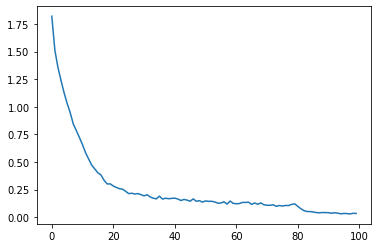

Final Train Accuracy:  0.989300012588501
Final Test Accuracy:  0.6646000146865845


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['acc'],'g',label="Training Accuracy")
ax.plot(history.history['val_acc'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history.history['acc'][-1])
print("Final Test Accuracy: ",history.history['val_acc'][-1])

### Standard augmentation:


In [ ]:
class Standard_augment(keras.utils.Sequence):

    def __init__(self, X, Y, batch_size, K, shuffle=False):

        self.X= X
        self.Y= Y
        self.batch_size = batch_size
        self.indices= list(np.arange(X.shape[0]))
        self.K=K
        self.shuffle = shuffle
        self.on_epoch_end()
        self.h, self.w, self.channels= X[0].shape

    def __len__(self):

        return int(np.ceil(len(X_train_t) / self.batch_size))

    def __getitem__(self, idx):
        index = self.idx[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
       
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x_aug= batch_x.copy()
        X_aug= self.__standard_augment(batch_x_aug, self.K)

        #normalize:
        X_aug= X_aug/255
        X_aug_mean = np.mean(X_aug, axis=0)
        X_aug_std= np.std(X_aug, axis=0)
        X_aug = (X_aug - X_aug_mean)/X_aug_std

        return X_aug, batch_y


    def __shift_image(self, img, k1, k2):
        v_shift= np.full(shape=(np.abs(k1), img.shape[1]), fill_value=0)

        if k1<0:
            #pad zero at top: move image downwards
            v_img=  np.vstack(tup=(v_shift, img))
        else:
            #pad zero at bottom: move image upwards
            v_img=  np.vstack(tup=(img, v_shift))
    
        h_shift= np.full(shape=(v_img.shape[0], np.abs(k2)), fill_value=0)
        if k2<0:
            #pad zero at right of image: move image to left
            hv_img=  np.hstack(tup=(v_img, h_shift))
        else:
            #pad zero at left of image: move image to right
            hv_img=  np.hstack(tup=(h_shift, v_img))

        return hv_img[:32, :32]

    def __standard_augment(self, train_img, K):
        flip_prob= np.random.uniform(0,1,self.batch_size)
        shift_list= np.random.randint(-K,K,size=(self.batch_size,2)) 
 
        for i in range(self.batch_size):
            img= train_img[i]
            r_image, g_image, b_image = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            k1= shift_list[i][0]
            k2= shift_list[i][1]

            r_new= self.__shift_image(r_image, k1, k2)
            g_new= self.__shift_image(g_image, k1, k2)
            b_new= self.__shift_image(b_image, k1, k2)

            image_trans = np.dstack(tup=(r_new, g_new, b_new))

            if flip_prob[i] >0.5:
                #flip horizontally
                image_trans= np.flip(image_trans, axis=1)
            train_img[i]= image_trans
        return train_img

    def on_epoch_end(self):
        self.idx = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.idx)


In [ ]:
#use un-normalized x_train and y_train. First augment and then normalize. Hence, converting original y_train to categorical feature as y_train used in previous cases were shuffled.

Y_train= tf.keras.utils.to_categorical(Y_train, len(unique_label))

In [ ]:
traingen= Standard_augment(X_train,  Y_train, batch_size, 4)

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])

#fit model
history= model.fit_generator(traingen, epochs=100,validation_data=(X_test_t, y_test_t), callbacks=callbacks, workers=6)
loss, acc = model.evaluate(X_test_t, y_test_t)

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 9s 65ms/step - loss: 2.2398 - accuracy: 0.2484 - val_loss: 2.3084 - val_accuracy: 0.2263
Epoch 2/100
Learning rate:  0.001
100/100 [==============================] - 6s 59ms/step - loss: 1.5380 - accuracy: 0.4295 - val_loss: 1.7051 - val_accuracy: 0.4042
Epoch 3/100
Learning rate:  0.001
100/100 [==============================] - 6s 58ms/step - loss: 1.3227 - accuracy: 0.5213 - val_loss: 2.3628 - val_accuracy: 0.2852
Epoch 4/100
Learning rate:  0.001
100/100 [==============================] - 6s 59ms/step - loss: 1.2211 - accuracy: 0.5540 - val_loss: 1.4350 - val_accuracy: 0.4924
Epoch 5/100
Learning rate:  0.001
100/100 [==============================] - 6s 59ms/step - loss: 1.1084 - accuracy: 0.6052 - val_loss: 1.8441 - val_accuracy: 0.4131
Epoch 6/100
Learning rate:  0.001
100/100 [==============================] - 6s 58ms/step - loss: 1.0325 - accuracy: 0.6294 - val_loss: 1.7241 - val_accuracy: 0.4638
Epoch 7/100
Learning rate:  0.001
100/

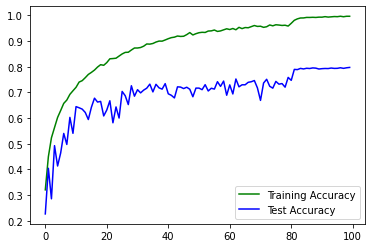

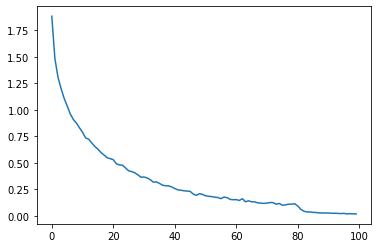

Final Train Accuracy:  0.9966999888420105
Final Test Accuracy:  0.7972999811172485


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['accuracy'],'g',label="Training Accuracy")
ax.plot(history.history['val_accuracy'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history.history['accuracy'][-1])
print("Final Test Accuracy: ",history.history['val_accuracy'][-1])

###  Combinining all augmentations for alpha= 0.4:

In [ ]:
class Combine_std_cutout_mixup(keras.utils.Sequence):

    def __init__(self, X, Y, batch_size, alpha, cut_out_K, std_K, shuffle=False):

        self.X= X
        self.Y= Y
        self.batch_size = batch_size
        self.indices= list(np.arange(X.shape[0]))
        self.cut_out_K=cut_out_K
        self.std_K= std_K
        self.alpha= alpha
        self.shuffle = shuffle
        self.on_epoch_end()
        self.h, self.w, self.channels= X[0].shape

    def __len__(self):
        return int(np.ceil(len(X_train_t) / self.batch_size))

    def __getitem__(self, idx):
      
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size]

        #standard augment
        batch_x_aug= batch_x.copy()
        X_aug= self.__standard_augment(batch_x_aug, self.std_K)

        #normalize:
        X_aug= X_aug/255
        X_aug_mean = np.mean(X_aug, axis=0)
        X_aug_std= np.std(X_aug, axis=0)
        X_aug = (X_aug - X_aug_mean)/X_aug_std

        #cutout
        for i in range(self.batch_size):
            prob = np.random.rand()
            if prob>0.5:
                #modify image
                X_aug[i]= self.__apply_mask(X_aug[i], self.cut_out_K)

        #mixup
        rand_index = np.random.choice(self.X.shape[0], self.batch_size, replace=False )
        shuffled_x= self.X[rand_index]
        shuffled_y= self.Y[rand_index]

        gamma= np.random.beta(self.alpha, self.alpha, self.batch_size) 
        x_l = tf.reshape(gamma, (self.batch_size, 1, 1, 1))
        y_l = tf.reshape(gamma, (self.batch_size, 1))
        
        X_new = X_aug * x_l + shuffled_x * (1 - x_l)
        Y_new = batch_y * y_l + shuffled_y * (1 - y_l) 
        #print('Y_new shape: ', Y_new.shape)
        return X_aug, batch_y


    def __apply_mask(self, image, size):
        y = np.random.randint(self.h)
        x = np.random.randint(self.w)
        y1 = np.clip(y - size // 2, 0, self.h)
        y2 = np.clip(y + size // 2, 0, self.h)
        x1 = np.clip(x - size // 2, 0, self.w)
        x2 = np.clip(x + size // 2, 0, self.w)
        image[y1:y2,x1:x2,:] = 0
        return image

    def __shift_image(self, img, k1, k2):
        v_shift= np.full(shape=(np.abs(k1), img.shape[1]), fill_value=0)

        if k1<0:
            #pad zero at top: move image downwards
            v_img=  np.vstack(tup=(v_shift, img))
        else:
            #pad zero at bottom: move image upwards
            v_img=  np.vstack(tup=(img, v_shift))
    
        h_shift= np.full(shape=(v_img.shape[0], np.abs(k2)), fill_value=0)
        if k2<0:
            #pad zero at right of image: move image to left
            hv_img=  np.hstack(tup=(v_img, h_shift))
        else:
            #pad zero at left of image: move image to right
            hv_img=  np.hstack(tup=(h_shift, v_img))

        return hv_img[:32, :32]

    def __standard_augment(self, train_img, K):
        flip_prob= np.random.uniform(0,1,self.batch_size)
        shift_list= np.random.randint(-K,K,size=(self.batch_size,2)) 
 
        for i in range(self.batch_size):
            img= train_img[i]
            r_image, g_image, b_image = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            k1= shift_list[i][0]
            k2= shift_list[i][1]

            r_new= self.__shift_image(r_image, k1, k2)
            g_new= self.__shift_image(g_image, k1, k2)
            b_new= self.__shift_image(b_image, k1, k2)

            image_trans = np.dstack(tup=(r_new, g_new, b_new))

            if flip_prob[i] >0.5:
                #flip horizontally
                image_trans= np.flip(image_trans, axis=1)
            train_img[i]= image_trans
        return train_img

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idx = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.idx)


In [ ]:
traingen= Combine_std_cutout_mixup(X_train,  Y_train, batch_size, 0.4, 16, 4)

In [ ]:
tf.keras.backend.clear_session()
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])

#fit model
history= model.fit_generator(traingen, epochs=100,validation_data=(X_test_t, y_test_t), callbacks=callbacks, workers=6)
loss, acc = model.evaluate(X_test_t, y_test_t)

Learning rate:  0.001
Epoch 1/100
Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 10s 74ms/step - loss: 2.1499 - accuracy: 0.2555 - val_loss: 2.9255 - val_accuracy: 0.1756
Epoch 2/100
Learning rate:  0.001
100/100 [==============================] - 7s 69ms/step - loss: 1.5936 - accuracy: 0.4117 - val_loss: 2.6078 - val_accuracy: 0.2138
Epoch 3/100
Learning rate:  0.001
100/100 [==============================] - 7s 67ms/step - loss: 1.4192 - accuracy: 0.4842 - val_loss: 1.6315 - val_accuracy: 0.4390
Epoch 4/100
Learning rate:  0.001
100/100 [==============================] - 7s 67ms/step - loss: 1.3307 - accuracy: 0.5121 - val_loss: 1.8411 - val_accuracy: 0.4452
Epoch 5/100
Learning rate:  0.001
100/100 [==============================] - 7s 67ms/step - loss: 1.2654 - accuracy: 0.5380 - val_loss: 1.6473 - val_accuracy: 0.4740
Epoch 6/100
Learning rate:  0.001
100/100 [==============================] - 7s 66ms/step - loss: 1.1649 - accuracy: 0.5846 - val_loss: 1.4135 - val_accuracy: 0.5237
Epoch 7/100
Learning rate:  0.001
100

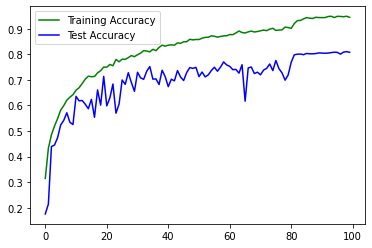

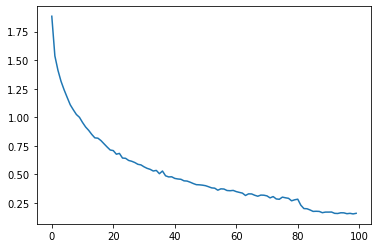

Final Train Accuracy:  0.9449999928474426
Final Test Accuracy:  0.8082000017166138


In [ ]:
plt.figure()
ax = plt.subplot(111)
ax.plot(history.history['accuracy'],'g',label="Training Accuracy")
ax.plot(history.history['val_accuracy'], 'b',label="Test Accuracy")
ax.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'],label="Training Loss")
plt.show()
print("Final Train Accuracy: ",history.history['accuracy'][-1])
print("Final Test Accuracy: ",history.history['val_accuracy'][-1])

The test accuracy increased as we combined all three data augmentation methods as compared to applying single data augmentation technique.

 ### Role of data augmentation



Test accuracy inceases from 63% when we are not doing any data augmentation to 80% when we are combining all three data augmentation methods.

Initially, the model was over-fitting the training data that's why we got low accuracy. As, the model started learning features with augmentation, it was able to genralize well to unseen data and hence, increase the accuracy on test set.



Train Loss converges very quickly when the data is not augmented. After applying augmentation, the training loss takes longer to converge due to introduced invariance in data. 